# Relpicating DeepOKAN paper


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from deepkan import RBFKAN  # Assuming the package provides this module


In [4]:
class DeepOKAN(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dims, output_dim):
        super(DeepOKAN, self).__init__()
        
        # Branch network using RBFKAN layers
        self.branch_net = RBFKAN([branch_input_dim] + hidden_dims + [output_dim], 
                                 grid_min=-2.0, 
                                 grid_max=2.0, 
                                 num_grids=8, 
                                 use_base_update=True, 
                                 base_activation=nn.SiLU(), 
                                 spline_weight_init_scale=0.1)
        
        # Trunk network using RBFKAN layers
        self.trunk_net = RBFKAN([trunk_input_dim] + hidden_dims + [output_dim], 
                                grid_min=-2.0, 
                                grid_max=2.0, 
                                num_grids=8, 
                                use_base_update=True, 
                                base_activation=nn.SiLU(), 
                                spline_weight_init_scale=0.1)
    
    def forward(self, branch_input, trunk_input):
        branch_output = self.branch_net(branch_input)
        trunk_output = self.trunk_net(trunk_input)
        
        # Combine the outputs element-wise
        output = torch.sum(branch_output * trunk_output, dim=1, keepdim=True)
        return output


In [5]:
def generate_data(num_samples, branch_input_dim, trunk_input_dim):
    branch_input = torch.randn(num_samples, branch_input_dim)
    trunk_input = torch.randn(num_samples, trunk_input_dim)
    
    # Target output for a synthetic problem
    target_output = torch.sin(torch.sum(branch_input, dim=1, keepdim=True)) + torch.cos(torch.sum(trunk_input, dim=1, keepdim=True))
    return branch_input, trunk_input, target_output

num_samples = 1000
branch_input_dim = 10
trunk_input_dim = 2
hidden_dims = [16, 32, 16]
output_dim = 1

branch_input, trunk_input, target_output = generate_data(num_samples, branch_input_dim, trunk_input_dim)


In [6]:
model = DeepOKAN(branch_input_dim=branch_input_dim, 
                 trunk_input_dim=trunk_input_dim, 
                 hidden_dims=hidden_dims, 
                 output_dim=output_dim)


In [7]:
criterion = nn.MSELoss()  # Example for a regression task
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [8]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    
    optimizer.zero_grad()
    outputs = model(branch_input, trunk_input)
    loss = criterion(outputs, target_output)
    
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.7251
Epoch [20/100], Loss: 0.5718
Epoch [30/100], Loss: 0.4871
Epoch [40/100], Loss: 0.4280
Epoch [50/100], Loss: 0.3753
Epoch [60/100], Loss: 0.3162
Epoch [70/100], Loss: 0.2568
Epoch [80/100], Loss: 0.2007
Epoch [90/100], Loss: 0.1552
Epoch [100/100], Loss: 0.1173


In [9]:
model.eval()
with torch.no_grad():
    predictions = model(branch_input, trunk_input)
    print(predictions)

tensor([[-1.6430e+00],
        [ 1.8766e+00],
        [-1.0448e-02],
        [-8.0586e-02],
        [ 1.8979e-01],
        [ 1.5861e+00],
        [ 2.9603e-01],
        [ 1.4977e+00],
        [-3.4745e-01],
        [-4.8849e-01],
        [ 1.8756e+00],
        [-4.6990e-01],
        [ 1.6154e+00],
        [ 4.5505e-01],
        [ 1.7346e-01],
        [-4.6303e-01],
        [ 7.6882e-01],
        [-1.8224e-01],
        [ 9.9316e-01],
        [ 3.8353e-01],
        [ 9.2832e-02],
        [ 8.6164e-01],
        [ 1.1289e+00],
        [ 1.4787e+00],
        [-3.0675e-01],
        [-2.4952e-01],
        [ 1.8201e+00],
        [ 3.0906e-03],
        [ 1.6491e-01],
        [ 9.6472e-01],
        [-3.4012e-01],
        [ 1.7757e+00],
        [ 1.4181e-01],
        [-3.3543e-01],
        [ 1.1834e+00],
        [ 1.5955e-01],
        [ 8.2188e-01],
        [ 9.3051e-01],
        [-1.1784e-01],
        [ 1.1644e+00],
        [-1.2508e+00],
        [ 9.1870e-02],
        [ 2.1692e-01],
        [-1

In [10]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(model, branch_input, trunk_input, target_output):
    model.eval()
    with torch.no_grad():
        predictions = model(branch_input, trunk_input)
    
    # Convert predictions and targets to numpy arrays
    predictions = predictions.numpy()
    target_output = target_output.numpy()
    
    # Calculate Mean Squared Error
    mse = mean_squared_error(target_output, predictions)
    
    # Calculate R-squared (coefficient of determination)
    r2 = r2_score(target_output, predictions)
    
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'R-squared: {r2:.4f}')
    
    return mse, r2


In [11]:
mse, r2 = evaluate_model(model, branch_input, trunk_input, target_output)

Mean Squared Error: 0.1151
R-squared: 0.8774


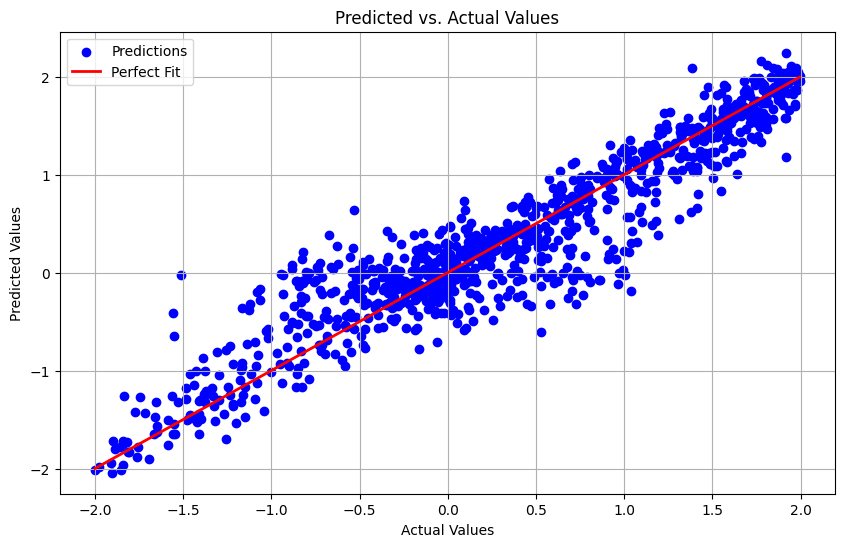

In [12]:
import matplotlib.pyplot as plt

def plot_predictions_vs_actuals(predictions, actuals):
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, predictions, color='blue', label='Predictions')
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red', linewidth=2, label='Perfect Fit')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predicted vs. Actual Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# Evaluate model and plot
predictions = model(branch_input, trunk_input).detach().numpy()
actuals = target_output.numpy()
plot_predictions_vs_actuals(predictions, actuals)

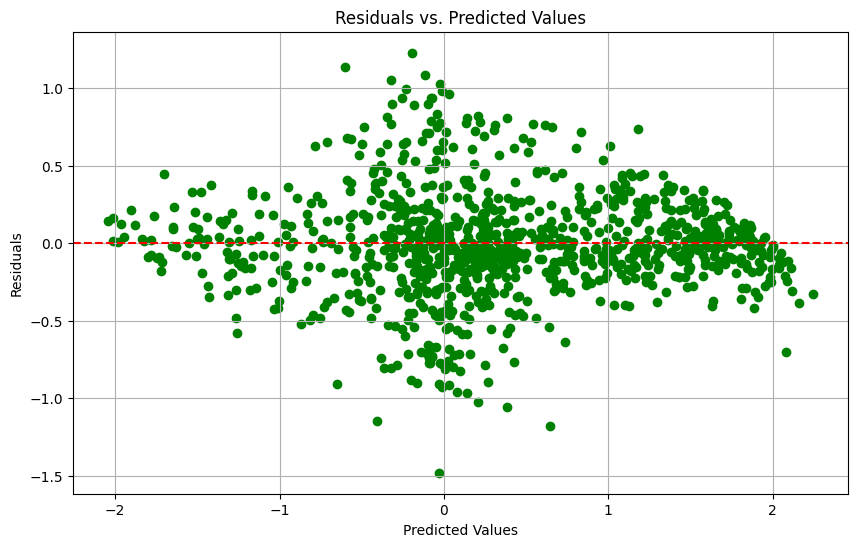

In [13]:
def plot_residuals(predictions, actuals):
    residuals = actuals - predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(predictions, residuals, color='green')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs. Predicted Values')
    plt.grid(True)
    plt.show()

plot_residuals(predictions, actuals)